### Explore the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import seaborn as sns
import tensorflow as tf
import PIL
import numpy as np
import pandas as pd
import tqdm
import cv2
import matplotlib.pyplot as plt
import shutil

In [3]:
import matplotlib as mpl
import matplotlib.image as mpimg

from PIL import Image, ImageOps
import scipy.ndimage as ndi

#from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense

from skimage import transform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support



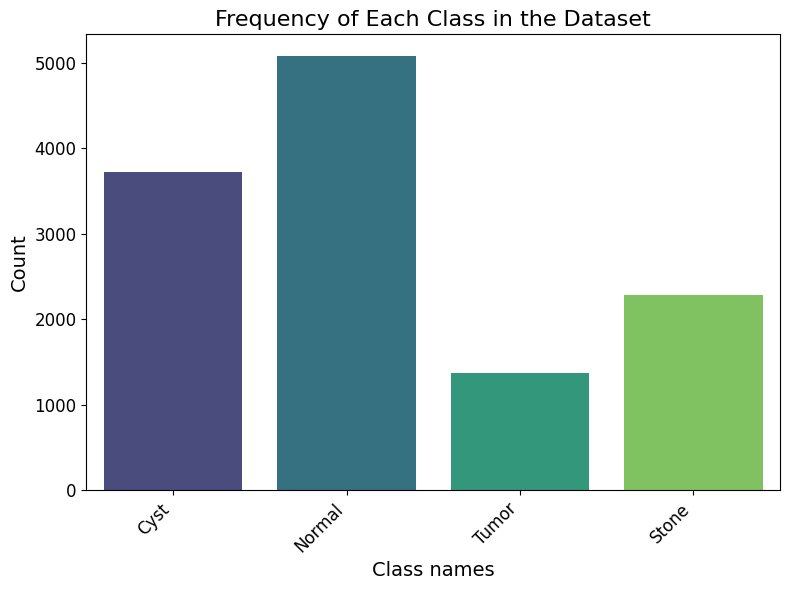

In [4]:
class_names = ['Cyst', 'Normal', 'Tumor', 'Stone']

cyst_path = '/content/drive/MyDrive/kaggle/raw/Cyst'
normal_path = '/content/drive/MyDrive/kaggle/raw/Normal'
stone_path = '/content/drive/MyDrive/kaggle/raw/Stone'
tumor_path = '/content/drive/MyDrive/kaggle/raw/Tumor'

cyst = len(os.listdir(cyst_path))
normal = len(os.listdir(normal_path))
stone = len(os.listdir(stone_path))
tumor = len(os.listdir(tumor_path))

images = [cyst, normal, stone, tumor]

plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=images, palette='viridis')

plt.title('Frequency of Each Class in the Dataset', fontsize=16)
plt.xlabel('Class names', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()  # Adjust spacing
plt.show()


### Load Processed Data

In [5]:
train_path = '/content/drive/MyDrive/kaggle/dataset/train'
test_path = '/content/drive/MyDrive/kaggle/dataset/test'
val_path = '/content/drive/MyDrive/kaggle/dataset/val'

In [6]:
from keras.preprocessing.image import ImageDataGenerator

In [7]:
train_datagen = ImageDataGenerator(rescale=1/255)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [8]:
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(200, 200),
                                                  color_mode='grayscale',
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  )

test_dataset = test_datagen.flow_from_directory(test_path,
                                                target_size=(200, 200),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size=100,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory(val_path,
                                                  target_size=(200, 200),
                                                  class_mode='categorical',
                                                  batch_size=100,
                                                  color_mode='grayscale',
                                                  )

Found 436 images belonging to 4 classes.
Found 128 images belonging to 4 classes.
Found 122 images belonging to 4 classes.


### Model - VGG - 16

In [9]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=train_dataset.image_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(256,(3,3),strides=(1, 1),padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),


    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax'),

])

In [10]:
import keras
METRICS = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

### Fit Model

In [11]:
model_fit = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch = 3,
                      epochs = 30)

Epoch 1/30
3/3 [==============================] - 61s 13s/step - loss: 1.4007 - accuracy: 0.2712 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3902 - val_accuracy: 0.3033 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 41s 17s/step - loss: 1.3845 - accuracy: 0.2839 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3858 - val_accuracy: 0.3852 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 48s 17s/step - loss: 1.3837 - accuracy: 0.3833 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3706 - val_accuracy: 0.4508 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
3/3 [==============================] - 38s 16s/step - loss: 1.3540 - accuracy: 0.3559 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3473 - val_accuracy: 0.4918 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
3/3 [==============================] - 38

In [12]:
#import pickle

#history_file = '/content/vgg.pkl'

#with open(history_file, 'wb') as f:
    #pickle.dump(model_fit.history, f)

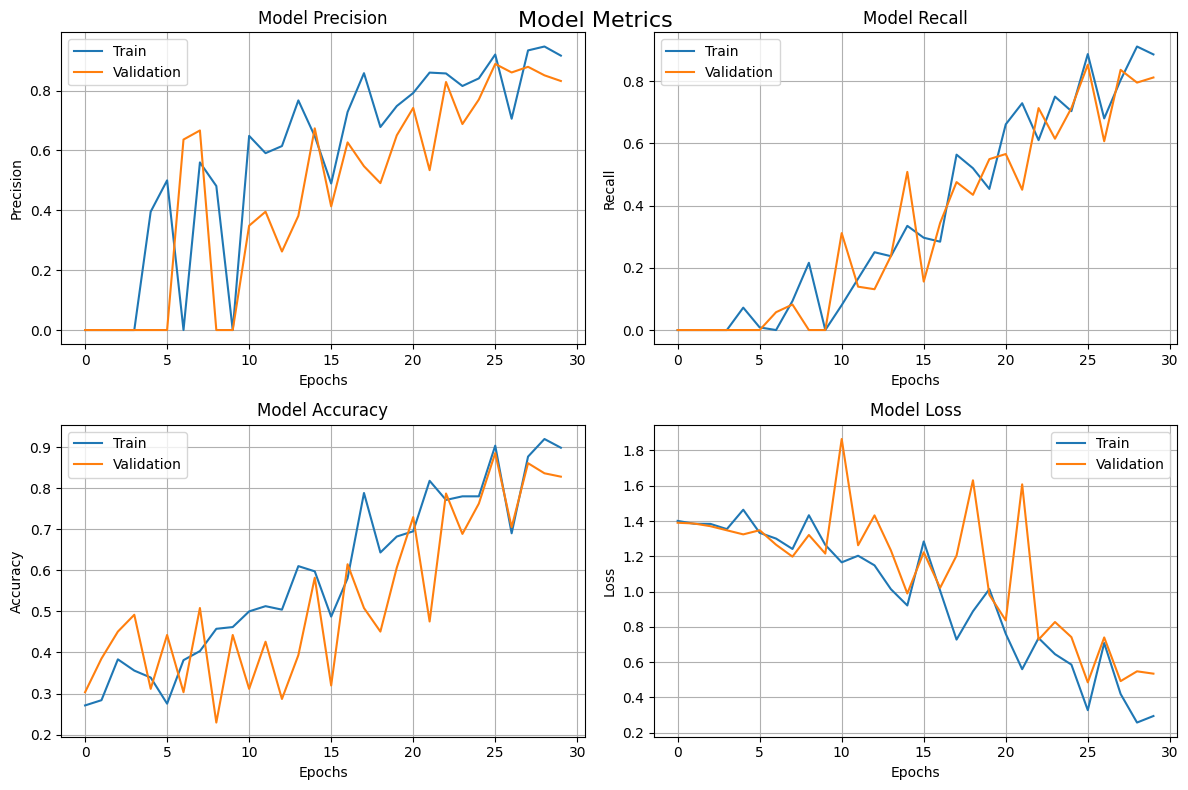

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # Increase the figure size for better visibility
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(model_fit.history[met], label='Train')
    ax[i].plot(model_fit.history['val_' + met], label='Validation')
    ax[i].set_title('Model {}'.format(met.capitalize()))  # Capitalize the metric name
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met.capitalize())  # Capitalize the metric name
    ax[i].legend()  # Show the legend with labels 'Train' and 'Validation'
    ax[i].grid(True)  # Add grid lines for better readability

# Add some space between subplots
plt.tight_layout()

# Add an overall title for the entire figure
fig.suptitle('Model Metrics', fontsize=16)

plt.show()


In [14]:
# Load the data from the pickle files
with open('/content/alexnet.pkl', 'rb') as f:
    alexnet_history = pickle.load(f)

with open('/content/vgg.pkl', 'rb') as f:
    vgg_history = pickle.load(f)

# Check the keys available in each dictionary
#print("Keys in alexnet_history:", alexnet_history.keys())
#print("Keys in vgg_history:", vgg_history.keys())

# Get the accuracy values for each model
alexnet_accuracy = [acc * 0.01 for acc in alexnet_history['training_accuracy']]
vgg_accuracy = vgg_history['accuracy']

# Calculate the count and percentage of most frequent accuracy
most_frequent_accuracy = max(set(alexnet_accuracy + vgg_accuracy), key=(alexnet_accuracy + vgg_accuracy).count)
count_most_frequent = (alexnet_accuracy + vgg_accuracy).count(most_frequent_accuracy)
percentage_most_frequent = count_most_frequent / len(alexnet_accuracy + vgg_accuracy) * 100

# Calculate top-1 accuracy
top1_accuracy_alexnet = max(alexnet_accuracy)
top1_accuracy_vgg = max(vgg_accuracy)

# Calculate average of top-5 accuracy
top5_accuracy_alexnet = sum(sorted(alexnet_accuracy, reverse=True)[:5]) / 5
top5_accuracy_vgg = sum(sorted(vgg_accuracy, reverse=True)[:5]) / 5

# Data for the bar plot
models = ['AlexNet', 'VGG']
count_most_frequent_list = [count_most_frequent, len(alexnet_accuracy + vgg_accuracy) - count_most_frequent]
percentage_most_frequent_list = [percentage_most_frequent, 100 - percentage_most_frequent]
top1_accuracy_list = [top1_accuracy_alexnet, top1_accuracy_vgg]
top5_accuracy_list = [top5_accuracy_alexnet, top5_accuracy_vgg]


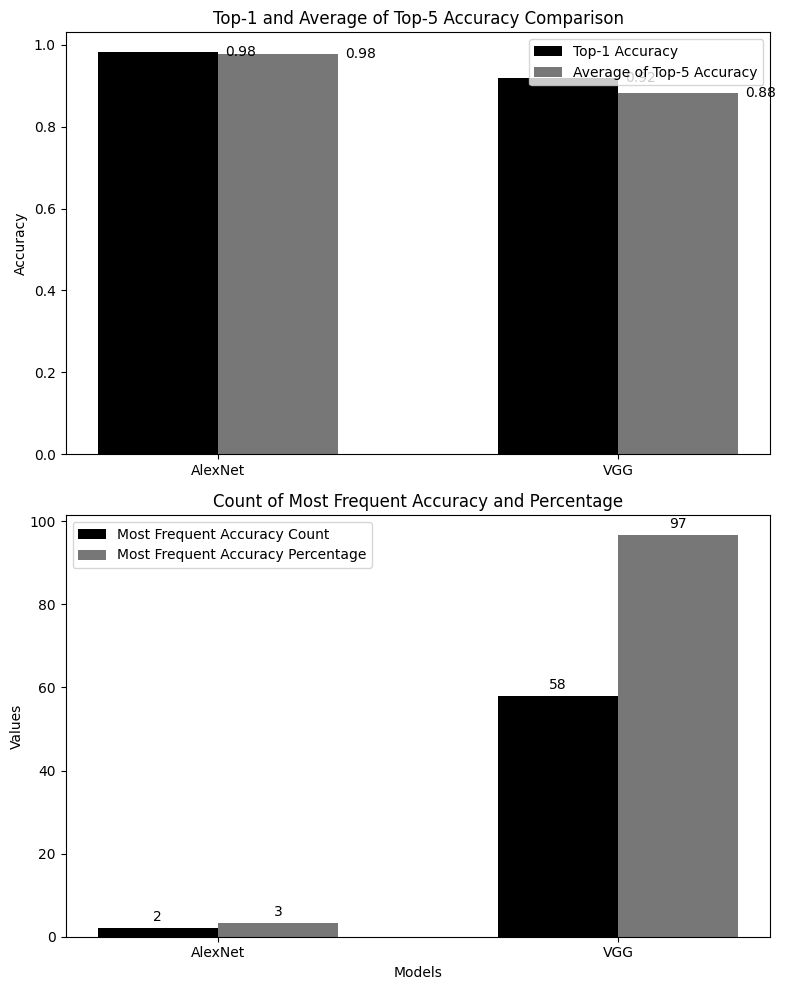

In [19]:
# Create a 2x1 subplot
fig, ax = plt.subplots(2, 1, figsize=(8, 10))

# Top section with top-1 accuracy and average of top-5 accuracy
bar_width = 0.3
index = range(len(models))

bar1 = ax[0].bar(index, top1_accuracy_list, bar_width, label='Top-1 Accuracy', color='#000000')
bar2 = ax[0].bar([i + bar_width for i in index], top5_accuracy_list, bar_width, label='Average of Top-5 Accuracy', color='#777777')

ax[0].set_ylabel('Accuracy')
ax[0].set_title('Top-1 and Average of Top-5 Accuracy Comparison')
ax[0].set_xticks([i + bar_width / 2 for i in index])
ax[0].set_xticklabels(models)
ax[0].legend()

# Bottom section with count of most frequent accuracy and percentage
bar3 = ax[1].bar(index, count_most_frequent_list, bar_width, label='Most Frequent Accuracy Count', color='#000000')
bar4 = ax[1].bar([i + bar_width for i in index], percentage_most_frequent_list, bar_width, label='Most Frequent Accuracy Percentage', color='#777777')

ax[1].set_xlabel('Models')
ax[1].set_ylabel('Values')
ax[1].set_title('Count of Most Frequent Accuracy and Percentage')
ax[1].set_xticks([i + bar_width / 2 for i in index])
ax[1].set_xticklabels(models)
ax[1].legend()

# Display the values on the bars in the top section
#for bar in [bar1, bar2]:
    #for rect in bar:
        #height = rect.get_height()
        #ax[0].annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                       #xytext=(0, 3), textcoords="offset points",
                       #ha='center', va='bottom', color='white')
for bar in [bar1, bar2]:
    for rect in bar:
        height = rect.get_height()
        width = rect.get_width()
        ax[0].annotate(f'{height:.2f}', xy=(rect.get_x() + width, height),
                       xytext=(5, 0), textcoords="offset points",
                       ha='left', va='center', color='black')

# Display the values on the bars in the bottom section
for bar in [bar3, bar4]:
    for rect in bar:
        height = rect.get_height()
        ax[1].annotate(f'{height:.0f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom')

# Save the plot if needed
#plt.savefig('/content/combined_barplot.png')
#plt.savefig('/content/combined_barplot.pdf')

# Show the plot
plt.tight_layout()
plt.show()

In [38]:
predictions = model.predict(test_dataset)

2/2 [==============================] - 7s 900ms/step


In [39]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

In [46]:
def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(12,10))
  conf_mat = confusion_matrix(actual, pre)
  sns.set(font_scale=1.5)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="gray_r", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()

Accuracy: 0.8125
Precision: 0.8114166519772019
Recall: 0.7553750866250867
F1_score: 0.7699874197466599


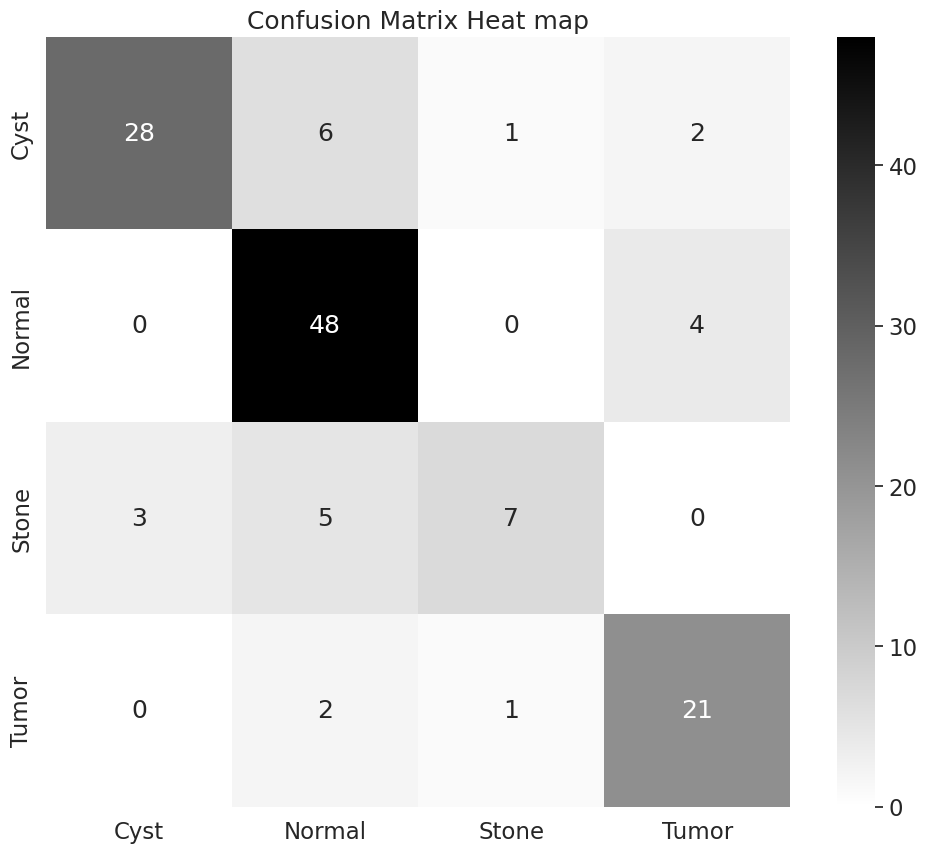

In [47]:
evaluate(test_dataset.classes,predictions)

In [ ]:
%%shell
jupyter nbconvert --to html /content/project3.ipynb

[NbConvertApp] Converting notebook /content/project3.ipynb to html
[NbConvertApp] Writing 825753 bytes to /content/project3.html
